# Wind-driven upwelling - 2 layer SWE analysis

***

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import gsw
import yaml
from datetime import datetime, timedelta
from dateutil.parser import parse
from matplotlib.colors import LogNorm
from cmocean import cm
from tqdm import tqdm_notebook as tqdm
from dynmodes import dynmodes
from salishsea_tools import viz_tools
from scipy import signal
from scipy.interpolate import griddata
from warnings import simplefilter

%matplotlib inline
plt.rcParams['font.size'] = 12
simplefilter('ignore')

***

### Local functions

In [2]:
def scaling_diagram():
    """Plot scaling diagram
    """
    
    x = np.arange(0, 1.01, 0.01)
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.xaxis.set_ticks([0, 0.1, 0.3, 1])
    ax.yaxis.set_ticks([0, 0.7, 0.9, 1])
    ax.xaxis.set_ticklabels([0, '$x_u$', '$R$', '$L$'])
    ax.yaxis.set_ticklabels(['$H$', '$z_h$', '$z_u$', 0])
    ax.plot([0.0, 1.0], [0.7, 0.7], 'k-')
    ax.plot(x, 0.2 * np.exp(-x / 0.3) + 0.7, 'k--')
    ax.plot(x, 0.3 * np.exp((0.1 - x) / 0.3) + 0.7, 'k--')
    ax.text(0.63, 0.89, '$\\frac{\\tau}{\\rho_0f}$', size=18)
    ax.text(0.05, 0.75, '$\\frac{z_u}{z_h} < 1$', size=18)
    ax.text(0.27, 0.91, '$\\frac{z_u}{z_h} > 1$', size=18)
    ax.arrow(0.6, 0.95, 0.1, 0, head_width=0.02, color='k')


def calc_rho(data, depth, tmask):
    """Calculate the density, rho
    """
    
    rho = gsw.rho(*[np.ma.masked_where(tmask == 0, data[k]) for k in tracers], depth)
    
    return rho

***

### Non-dimensional parameters

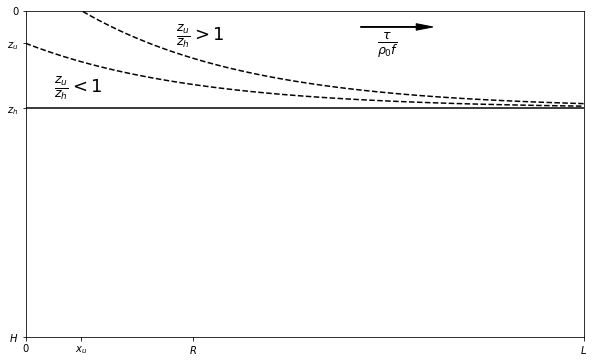

In [3]:
scaling_diagram()

***

From Csanady 1981, the baroclinic mode momentum balance is

$$
\begin{align}
\frac{\partial\mathbf{U}}{\partial t} + f\nabla\times\mathbf{U} & = -g'z_h\nabla\xi - \frac{\tau}{\rho_0} \nonumber \\
\nabla\cdot\mathbf{U} & = -\frac{\partial\xi}{\partial t} \nonumber
\end{align}
$$

Steady wind impulse at $t = 0$ yields the solution

$$
\xi(x) = -\left(\tau_yt + \frac{\tau_x}{f}\right)\frac{e^{x/R}}{\rho_0fR} \nonumber
$$
where
$$
R = \frac{\sqrt{g'z_h}}{f} \nonumber
$$
At the coast, $x=0$ (substitute $z_u = -\xi$)
$$
\boxed{\hspace{0.5cm}\frac{z_u}{z_h} = \frac{\tau_yt + \tau_xf^{-1}}{\rho_0fz_hR}} \nonumber
$$

***

### NetCDF files and definitions

In [4]:
# Load subdomains and sections from YAML
with open('parameters.yaml') as f: subdomains, sections, dates_northerly, dates_southerly = yaml.safe_load_all(f)

bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc')
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
coords = xr.open_dataset('/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)
bathy = bathy.isel(x=slice(*subdomains['ideal'][:2]), y=slice(*subdomains['ideal'][2:]))
mask = mask.isel(x=slice(*subdomains['ideal'][:2]), y=slice(*subdomains['ideal'][2:]))
coords = coords.isel(x=slice(*subdomains['ideal'][:2]), y=slice(*subdomains['ideal'][2:]))

# Define path and filename string
path = '/data/bmoorema/results/Lake/S4d'
fn = 'SalishSeaIdeal_1h_20170701_20170706_grid_T.nc'
depth2d = np.expand_dims(mask.gdept_1d[0, :], axis=1)
tmask = mask.tmask[0, ...]
const = {'g': 9.81, 'f': 1.11e-4, 'rho_0': 1024, 'H': 200, 'R': 5e3, 'z_h': 10}
jmax, jsub = 440, 5
hour = 24
e1t = 440
radius = 2
tracers = ['vosaline', 'votemper']

# Define scaling parameters
param = {
    'u_wind': [5, 10, 15],
    'tau': [0.034, 0.123, 0.280],
    'z_h': [10, 15, 20],
    'rho_surf': [1016, 1018, 1020],
}

# Build storage dict
runs = {}
for z_h in param['z_h']:
    runs[z_h] = {}
    for rho_s in param['rho_surf']:
        runs[z_h][rho_s] = {}
        for U in param['u_wind']:
            runs[z_h][rho_s][U] = {}
            for key in ['tau', 'z_u', 'x_u']:
                runs[z_h][rho_s][U][key] = []

***

### Define coastline indices and angles

In [5]:
# Make coastline indices
mask_trimmed = mask.tmask[0, ...].values
mask_trimmed[:, :130, :125] = 0
mask_trimmed[:, :50, :147] = 0
index = [147]
for row_s, row_d in zip(mask_trimmed[0, ...], mask_trimmed[30, ...]):
    i_s = np.where(np.diff(row_s) > 0)[0]
    i_d = np.where(np.diff(row_d) > 0)[0]
    if i_d.size:
        i_s = i_s[i_s < i_d[0]]
        if i_s.size: index.append(i_s[-1])
        else: index.append(index[-1])
    else: index.append(index[-1])
index = index[1:]
window = signal.get_window('blackman', 10)
index_smooth = signal.convolve(index, window / sum(window), mode='same')
slope = np.diff(index_smooth)
jindex = mask.y[:jmax][::jsub].values
index = index[:jmax][::jsub]
slope = slope[:jmax][::jsub]

***

### Process runs

In [7]:
# Loop though z_h, rho_surf and tau
for z_h in tqdm(param['z_h']):
    for rho_s in param['rho_surf']:
        
        # Calculate R
        R = np.sqrt(const['g'] * (const['rho_0'] - rho_s) / const['rho_0'] * z_h) / const['f']
        runs[z_h][rho_s]['R'] = R
        
        # Loop through windspeed
        for U, t in zip(param['u_wind'], param['tau']):

            # Open results record
            runID = f'SalishSeaPond_S4d{U:02d}ms_halocline{z_h:2d}m_rhosurf{rho_s:4d}'
            file = os.path.join(path, runID, fn)
            if os.path.exists(file):
                with xr.open_dataset(file) as data:

                    # Loop through sections
                    for i, j, s in zip(index, jindex, slope):
                        
                        # Lengthscale
                        L = int(radius * R / abs(np.cos(np.arctan(s))) / e1t)
                        
                        # Calculate stratification parameters
                        rho_t0 = calc_rho(data.isel(time_counter=0, y=j, x=slice(i, None)), depth2d, tmask[:, j, i:])
                        rho_halo = rho_t0[abs(depth2d[:, 0] - z_h).argmin(axis=0), :L].mean()

                        # Calculate tau
                        tau = (hour - 3) * 3600 * t

                        # Calculate upwelling metrics
                        rho = calc_rho(data.isel(time_counter=hour, deptht=0, y=j, x=slice(i, None)), 0, tmask[0, j, i:])
                        rho_max = rho[:L].max()
                        z_u = depth2d[int(np.median(abs(rho_t0[:, :L] - rho_max).argmin(axis=0))), 0]
                        x_u = np.cos(np.arctan(s)) * (rho >= rho_halo).sum() * e1t
                        
                        for key, var in zip(['tau', 'z_u', 'x_u'], [tau, z_u, x_u]):
                            runs[z_h][rho_s][U][key].append(var)

***

### Plot results

In [29]:
def plot_results(angle=None):
    """
    """

    # Wind fraction
    long = np.sin(np.arctan(2) - np.arctan(slope))
    cross = -np.cos(np.arctan(2) - np.arctan(slope))
    
    # Init arrays and make plot area
    x, y, s, z_u, x_u = np.empty(0), np.empty(0), np.empty(0), np.empty(0), np.empty(0)
    fig, axs = plt.subplots(1, 4, figsize=(13, 9), gridspec_kw={'width_ratios': [1, 1, 0.5, 2], 'wspace': 0.1})
    caxs = [fig.add_axes([xpos, 0.05, 0.16, 0.01]) for xpos in [0.125, 0.305]]

    # Concatenate arrays across runs
    for z_h in param['z_h']:
        for rho_s in param['rho_surf']:
            for U in param['u_wind']:
                x = np.concatenate((x,
                    np.array(runs[z_h][rho_s][U]['tau']) / (const['rho_0'] * const['f'] * z_h * np.array(runs[z_h][rho_s]['R'])),
                ))
                y = np.concatenate((y, jindex))
                s = np.concatenate((s, slope))
                z_u = np.concatenate((z_u, np.array(runs[z_h][rho_s][U]['z_u']) / z_h))
                x_u = np.concatenate((x_u, np.array(runs[z_h][rho_s][U]['x_u']) / runs[z_h][rho_s]['R']))

    if angle is 'long':
        x = x * np.sin(np.arctan(2) - np.arctan(s))
    elif angle is 'both':
        x = x * np.sin(np.arctan(2) - np.arctan(s)) - x/86400/const['f'] * np.cos(np.arctan(2) - np.arctan(s))
    
    # Interpolate to contour grid and plot results
    xi, yi = np.meshgrid(np.arange(0, 4, 0.1), np.arange(jmax))
    for ax, cax, z, vmax, cmap, label in zip(axs[:2], caxs, [z_u, x_u], [3.1, 4.1], [cm.thermal, cm.haline], ['$z_u/z_h$', '$x_u/R$']):
        data = griddata((x, y), z, (xi, yi), method='linear')
        c = ax.contourf(xi, yi, data, levels=np.arange(0, vmax, 0.1), cmap=cmap, extend='max')
        ax.plot(x, y, 'ko', markersize=2)
        ax.set_xlim([0, 3.4])
        ax.set_xlabel('$I_N(\\tau)/(\\rho_0fz_hR)$')
        fig.colorbar(c, cax=cax, orientation='horizontal', label=label, ticks=[0, 1, 2, 3, 4])

    # Plot wind angle geometry
    for xpos in [-1, 0, 1]: axs[2].plot([xpos, xpos], [20, 380], 'k--')
    axs[2].plot(long, jindex)
    axs[2].plot(cross, jindex)
    axs[2].set_xlim([-1.1, 1.1])
    axs[2].set_xlabel('Wind fraction')

    # Plot coastline reference
    axs[3].contourf(bathy.Bathymetry, cmap=cm.deep)
    axs[3].contourf(tmask[0, ...], levels=[-0.01, 0.01], colors='lightgray')
    axs[3].contour(tmask[0, ...], levels=[-0.01, 0.01], colors='k')
    axs[3].plot(index, jindex, '-', color='magenta')
    axs[3].set_xlim([0, 250])
    axs[3].set_xlabel('Subdomain grid X')
    viz_tools.set_aspect(axs[3])
    for ax, col in zip(axs, range(4)):
        ax.set_ylim([20, 380])
        if col > 0: ax.yaxis.set_ticklabels('')
        else: ax.set_ylabel('Subdomain grid Y')

    return fig, axs

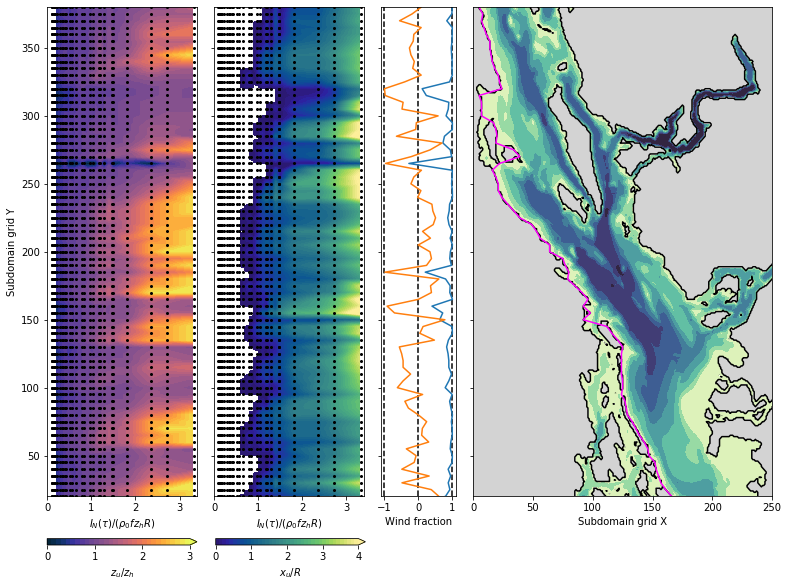

In [24]:
fig, axs = plot_results()

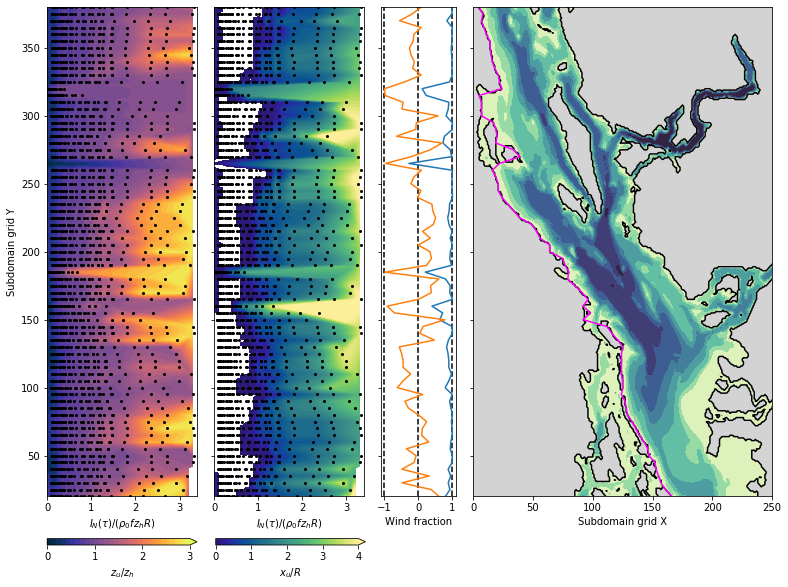

In [27]:
fig, axs = plot_results(angle='long')

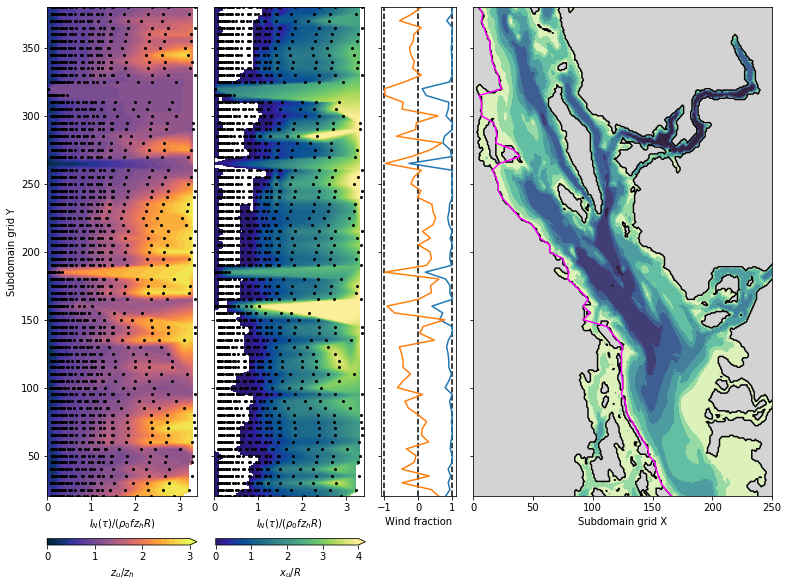

In [30]:
fig, axs = plot_results(angle='both')